<H3> In this notebooke we actually create the VAE and train on the stock chart images

In [16]:
import VAE_model
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import glob
import os
from utils import *

data_input_dir = '\\dataset'
image_count = 500

image_list=[]
for idx, image in enumerate(glob.glob(pathname=os.getcwd()+data_input_dir+'\\*.npy')):
    if idx==image_count:
        break
    image_list.append(np.load(image))
dataset = torch.tensor(np.asarray(image_list), dtype=torch.float)

#load image_count images as np arrays and convert to torch tensor
print(dataset.shape)

torch.Size([500, 3, 100, 104])


<h3>Dataloader to create batches and shuffle the data

In [17]:
batch_size=100
test, train = torch.utils.data.random_split(dataset, [0.2,0.8])

train_sampler= torch.utils.data.RandomSampler(train)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, sampler=train_sampler)
test_sampler= torch.utils.data.RandomSampler(test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, sampler=test_sampler)


In [20]:
torch.cuda.empty_cache()
# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
lr=0.0005
model = VAE_model.AE().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list=[]
# Train the model
for epoch in range(1):
    for idx, (images) in enumerate(train_dataloader):
        images.to('cuda')
        output = model(images.to('cuda')).to('cuda')
        loss = criterion(output, images.to('cuda'))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_list.append(loss.item())

    # Print loss
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')


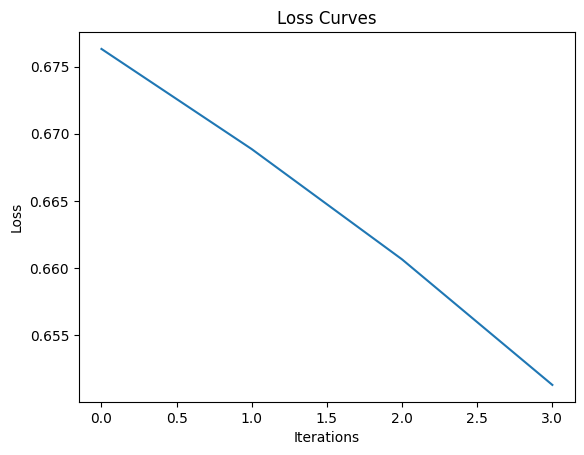

In [21]:
loss_plot(loss_list)

In [28]:
torch.max(output[0])

tensor(33.7709, device='cuda:0', grad_fn=<MaxBackward1>)

In [34]:
np.save('test.npy',np.round(torch.sigmoid(output[70,:,:,:].to('cpu').detach())))
np.save('test_real.npy',np.round(torch.sigmoid(images[70,:,:,:].to('cpu').detach())))

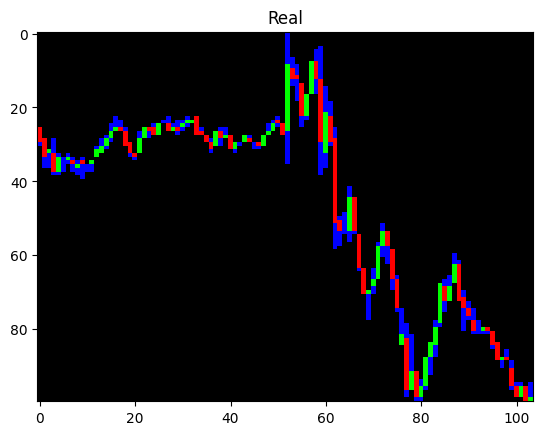

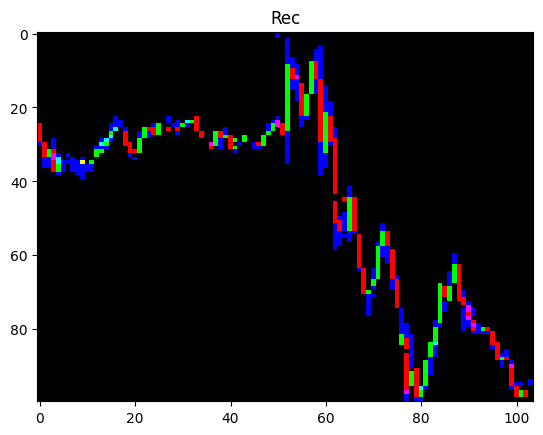

In [35]:
plt.title("Real")
plt.imshow(np.load('test_real.npy').transpose((1,2,0)), interpolation='none', aspect='auto')
plt.show()

plt.title("Rec")
plt.imshow(np.load('test.npy').transpose((1,2,0)), interpolation='none', aspect='auto')
plt.show()

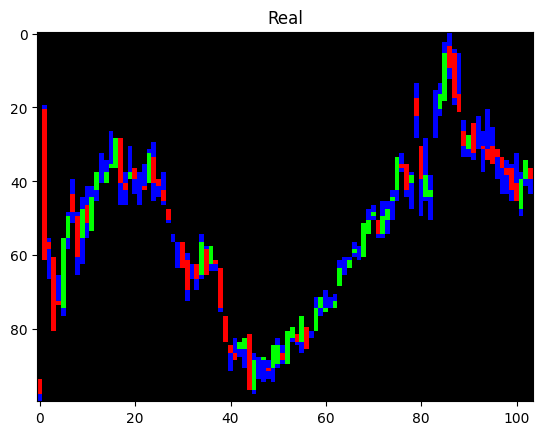

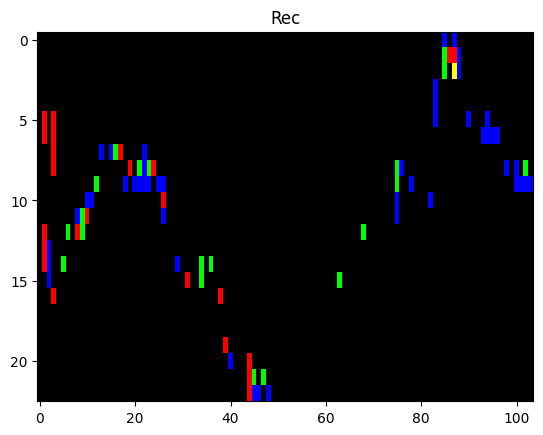

In [39]:
# testing new pictures
t2 = torch.tensor(np.asarray(np.load('dataset/4-623.npy')),dtype=torch.float).to('cuda')
t2_p = np.round(torch.sigmoid(model(t2).to('cpu').detach()))

np.save('test.npy',np.round(torch.sigmoid(t2_p.to('cpu').detach())))
np.save('test_real.npy',np.round(torch.sigmoid(t2.to('cpu').detach())))


plt.title("Real")
plt.imshow(np.load('test_real.npy').transpose((1,2,0)), interpolation='none', aspect='auto')
plt.show()

plt.title("Rec")
plt.imshow(np.load('test.npy').transpose((1,2,0)), interpolation='none', aspect='auto')
plt.show()

In [111]:
a = torch.nn.Conv2d(3,100,kernel_size=(3),padding='same')
b = torch.nn.ReLU()
c = torch.nn.MaxPool2d((2,2))
d = torch.nn.Conv2d(100,50,kernel_size=(3), padding='same')
e = torch.nn.ReLU()
f = torch.nn.MaxPool2d((2,2))
g = torch.nn.Conv2d(50,50,kernel_size=(3), padding='same')
h = torch.nn.ReLU()

i = torch.nn.MaxPool2d((2,2))


j = torch.nn.Conv2d(50,50,kernel_size=(3),padding='same')
k = torch.nn.ConvTranspose2d(50,100,kernel_size=(3), padding='same')
l = torch.nn.Conv2d(50,50,kernel_size=(3),padding='same')
m = torch.nn.Upsample((2,2),mode='nearest')

print(out_9.shape)
print(out_10.shape)

out_0 = a(dataset[0])
out_1 = b(out_0)
out_2 = c(out_1)
out_3 = d(out_2)
out_4 = e(out_3)
out_5 = f(out_4)
out_6 = g(out_5)
out_7 = h(out_6)
out_8 = i(out_7)
out_9 = j(out_8)
out_10 = k(out_9)
# out_11 = j(out_10)
# out_12 = k(out_11)



print(out_9.shape)
print(out_10.shape)
# print(out_11.shape)
# print(out_12.shape)

torch.Size([12, 12, 12])
torch.Size([50, 12, 2])


TypeError: conv_transpose2d(): argument 'padding' (position 5) must be tuple of ints, not tuple